In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext lab_black
from sklearn.linear_model import LinearRegression

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Try linear regression but with a filter on population

In [29]:
test = pd.read_csv("../data/raw/test.csv")
train = pd.read_csv("../data/raw/train.csv")

In [30]:
train["first_day_of_month"] = pd.to_datetime(train["first_day_of_month"])

In [31]:
test["first_day_of_month"] = pd.to_datetime(test["first_day_of_month"])
test = test.sort_values(["cfips", "first_day_of_month"])

In [32]:
test.head(20)

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
3135,1001_2022-12-01,1001,2022-12-01
6270,1001_2023-01-01,1001,2023-01-01
9405,1001_2023-02-01,1001,2023-02-01
12540,1001_2023-03-01,1001,2023-03-01
15675,1001_2023-04-01,1001,2023-04-01
18810,1001_2023-05-01,1001,2023-05-01
21945,1001_2023-06-01,1001,2023-06-01
1,1003_2022-11-01,1003,2022-11-01
3136,1003_2022-12-01,1003,2022-12-01


In [33]:
# print length of unique cfips for train and test
print("unique cfips for train and test")
print(len(train["cfips"].unique()))
print(len(test["cfips"].unique()))

unique cfips for train and test
3135
3135


In [34]:
train["cfips"].value_counts()

1001     39
39133    39
39089    39
39091    39
39093    39
         ..
21113    39
21115    39
21117    39
21119    39
56045    39
Name: cfips, Length: 3135, dtype: int64

### We try out a linear regression using the last month as our target for each county

In [35]:
ids = train["cfips"].unique()
x_train = np.arange(39).reshape((-1, 1))
x_test = np.arange(39, 47).reshape((-1, 1))
threshold = 0.1

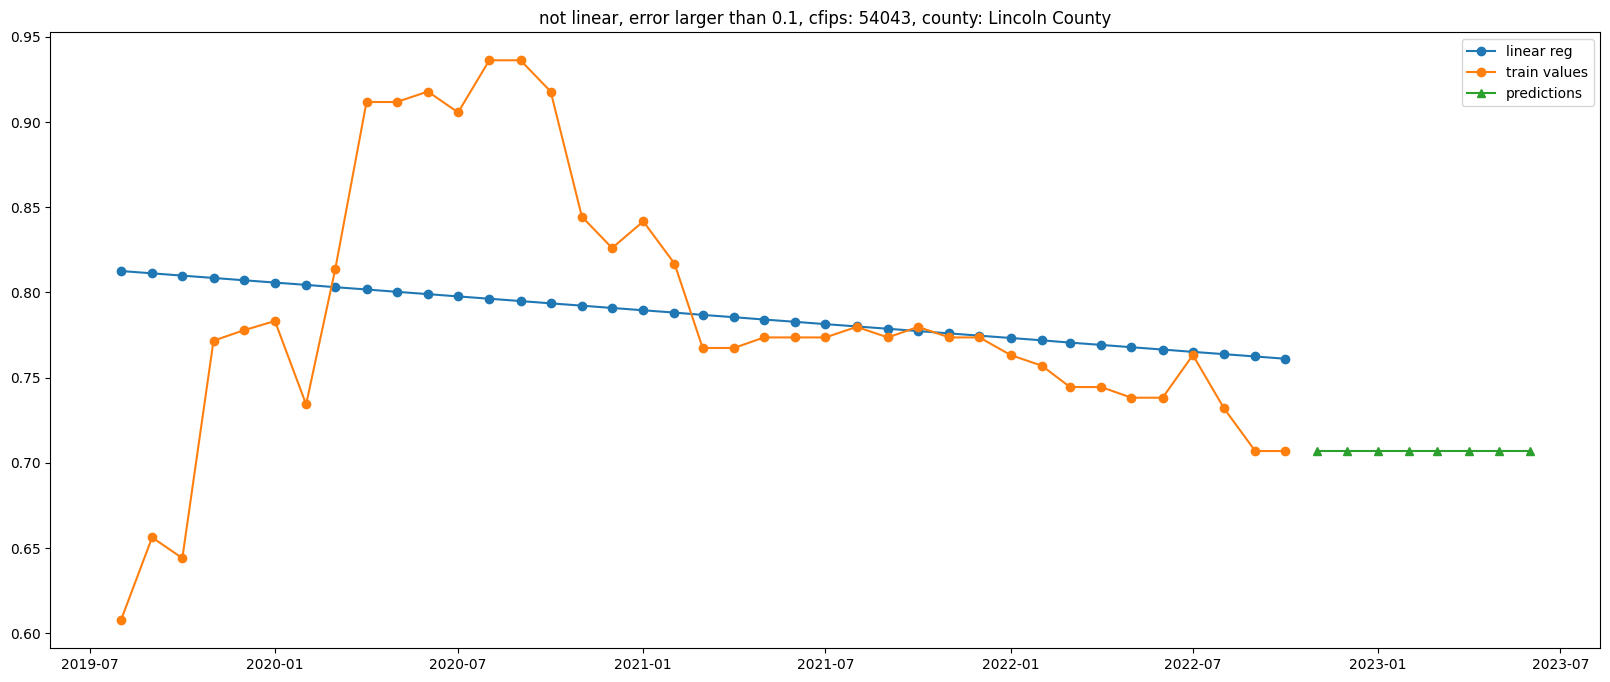

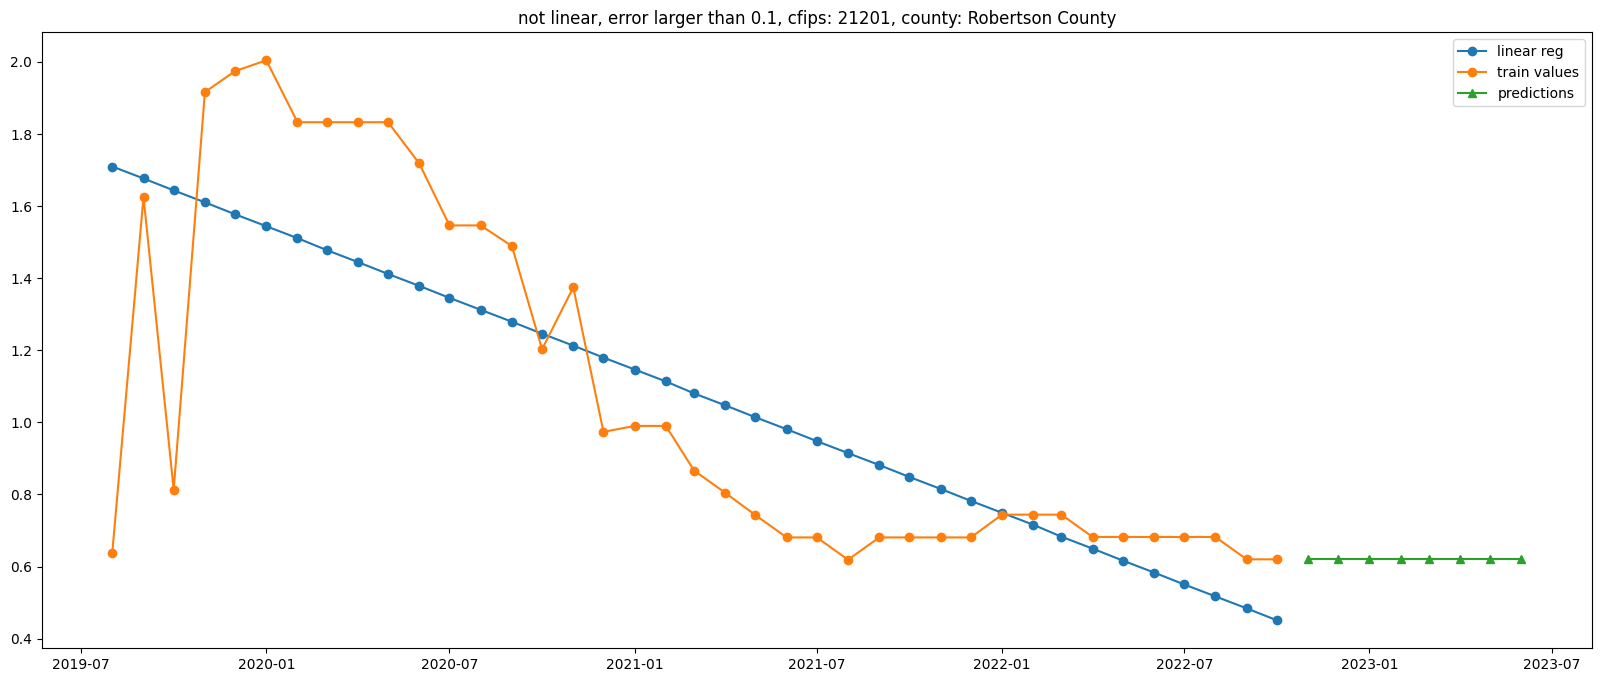

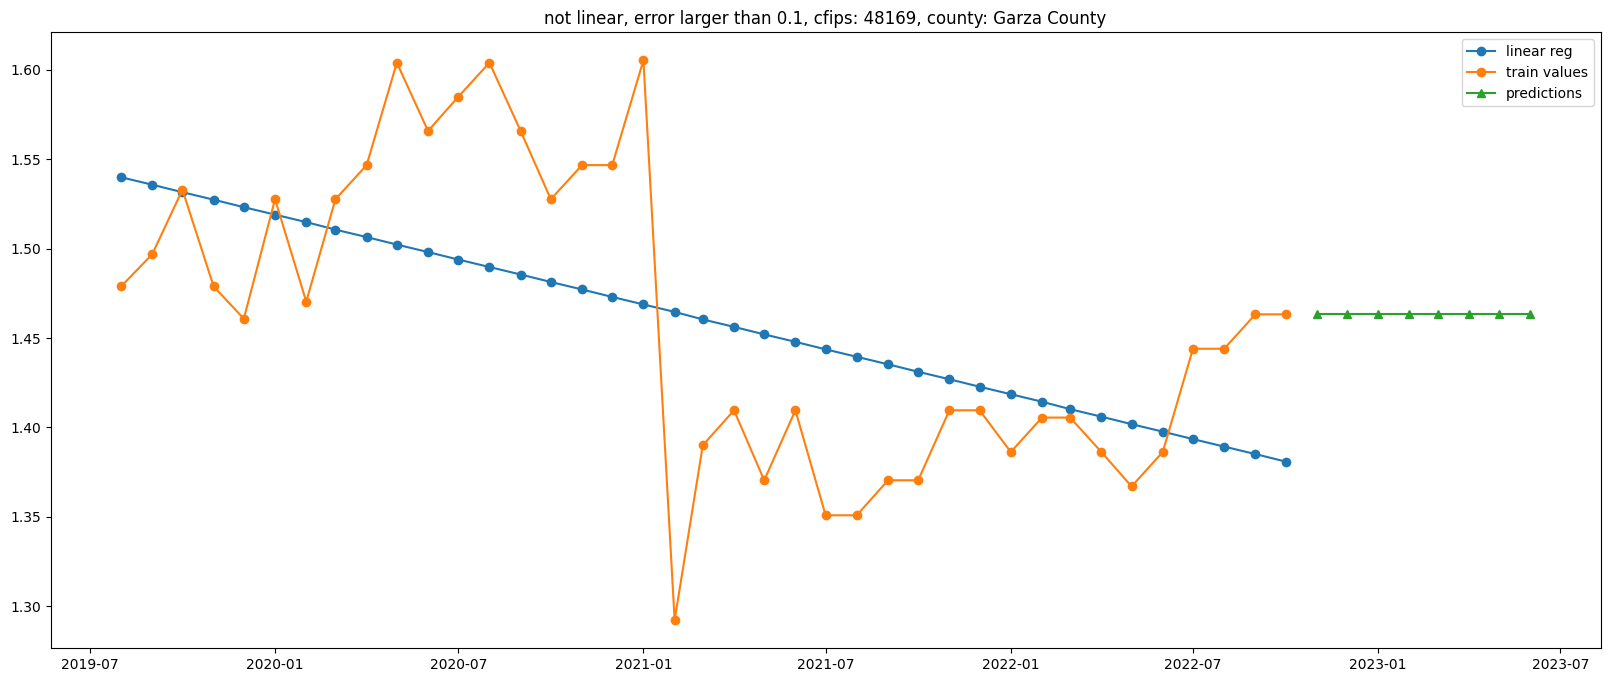

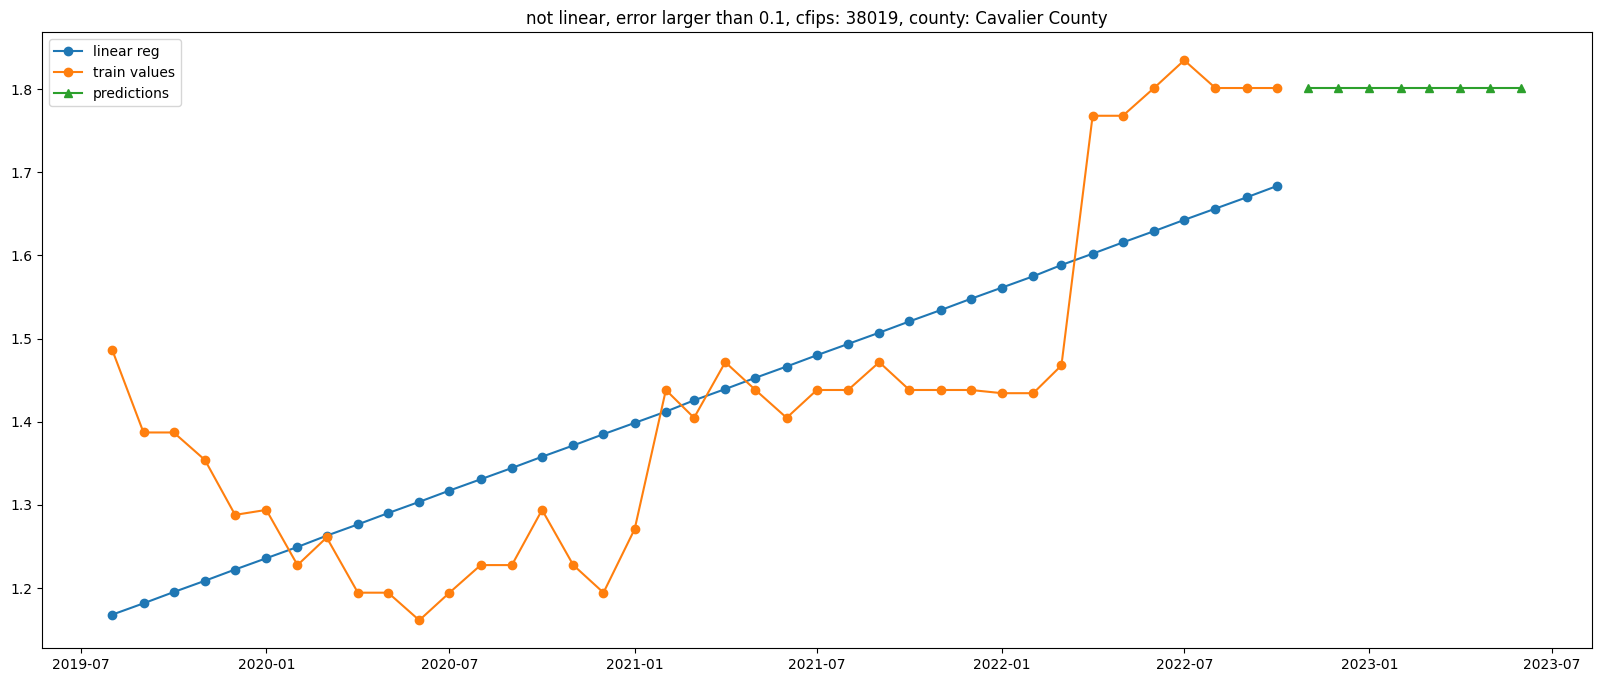

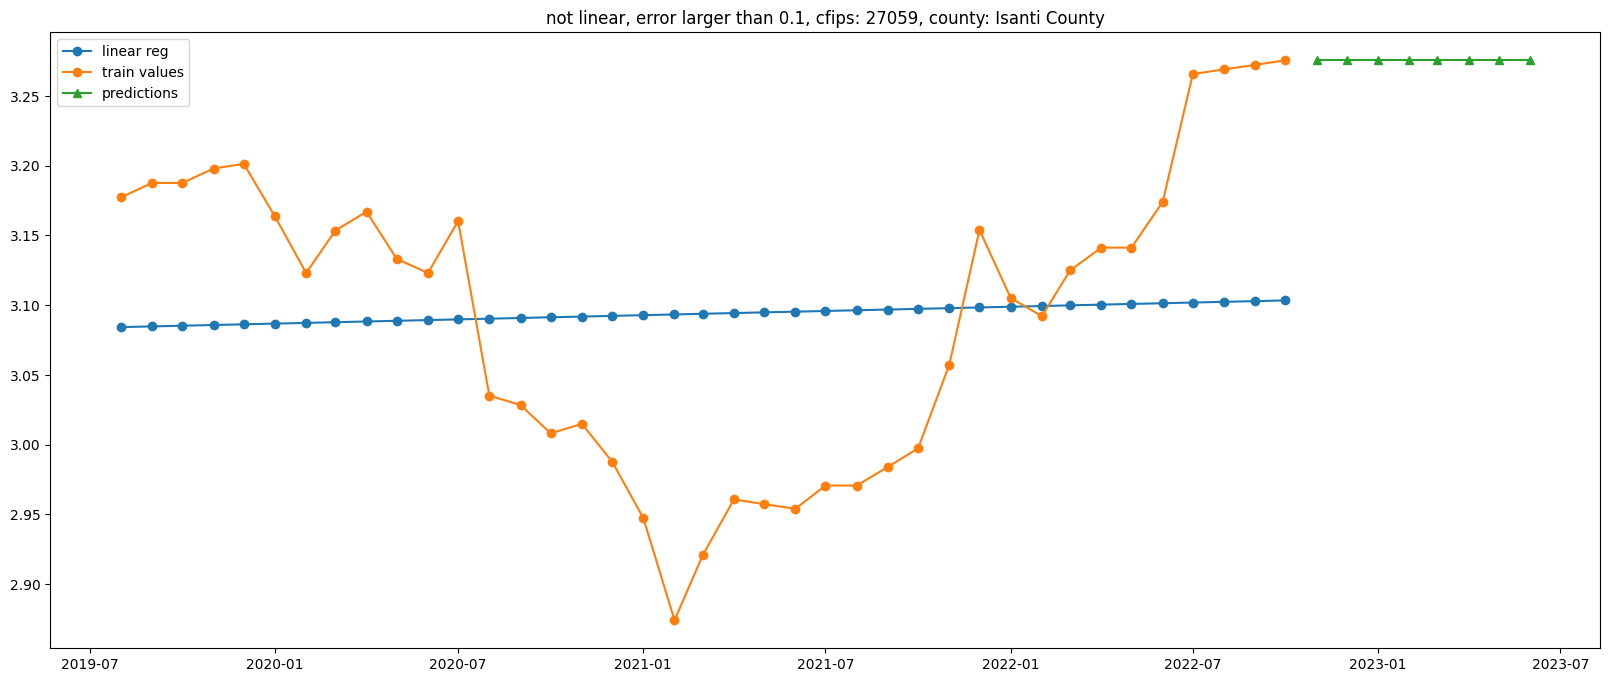

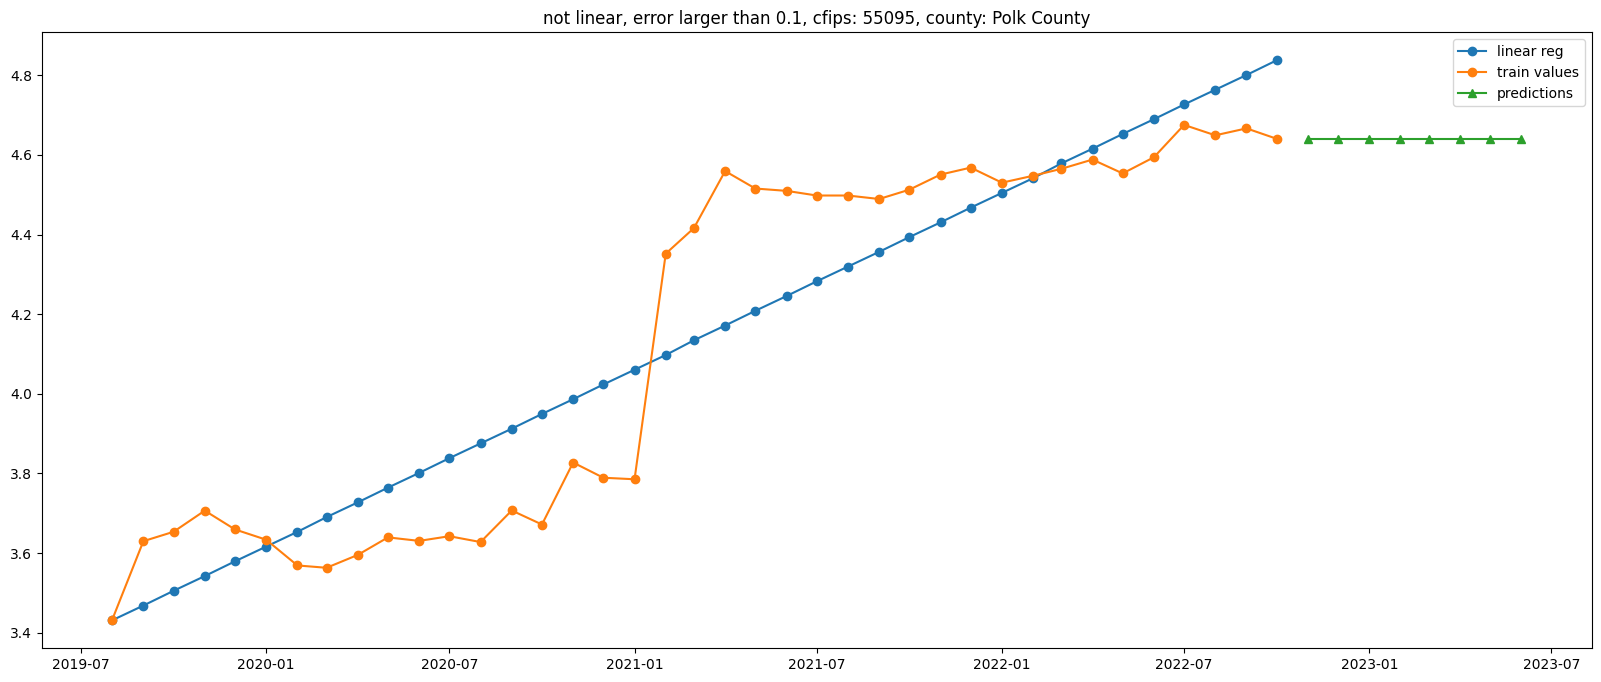

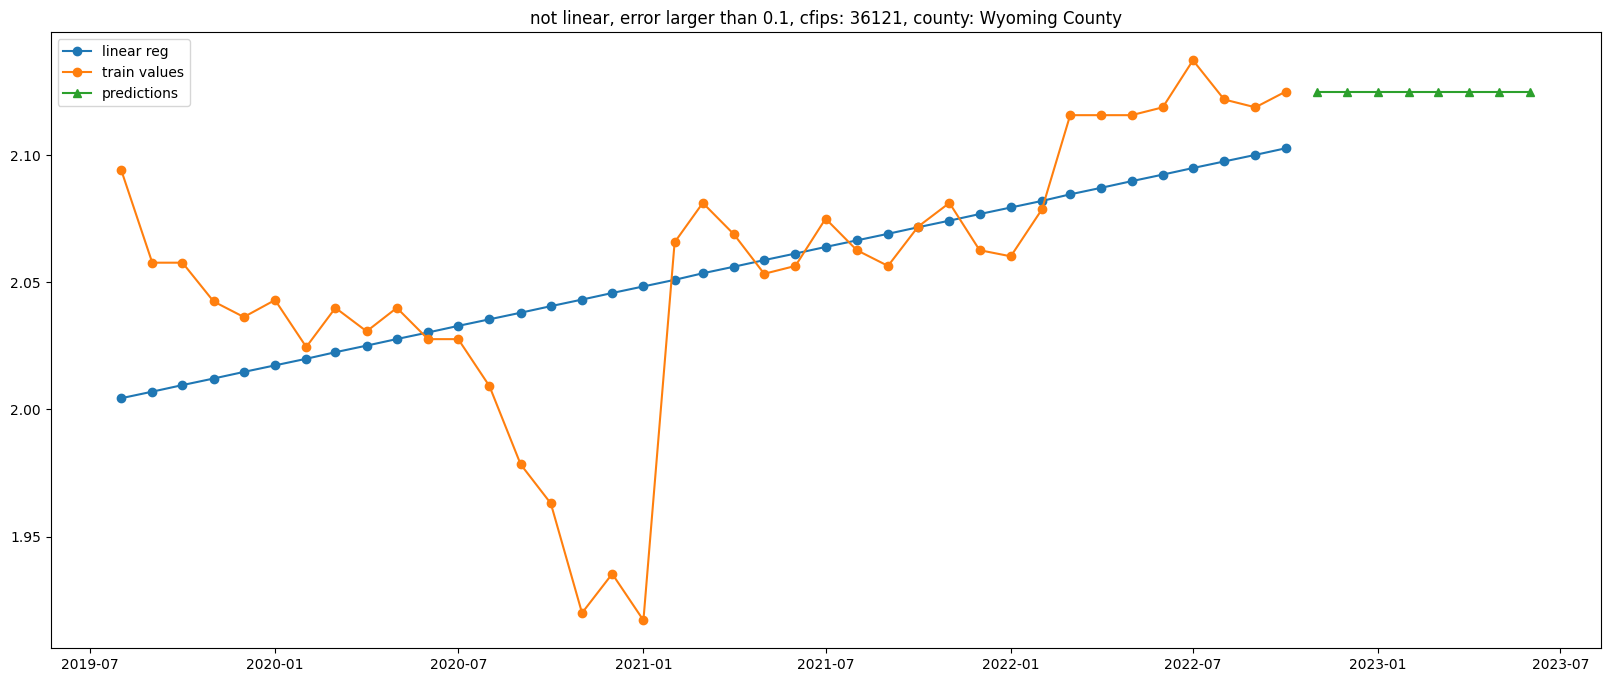

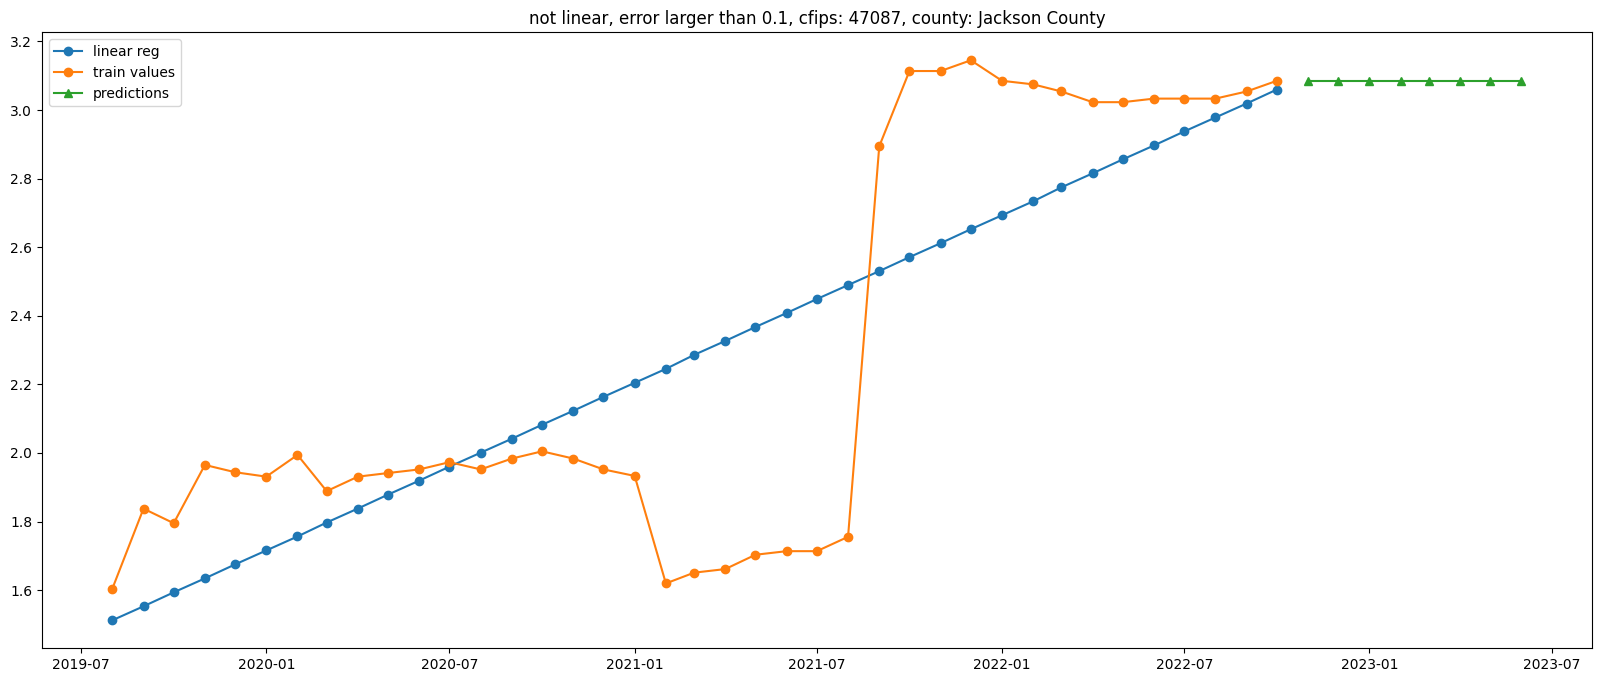

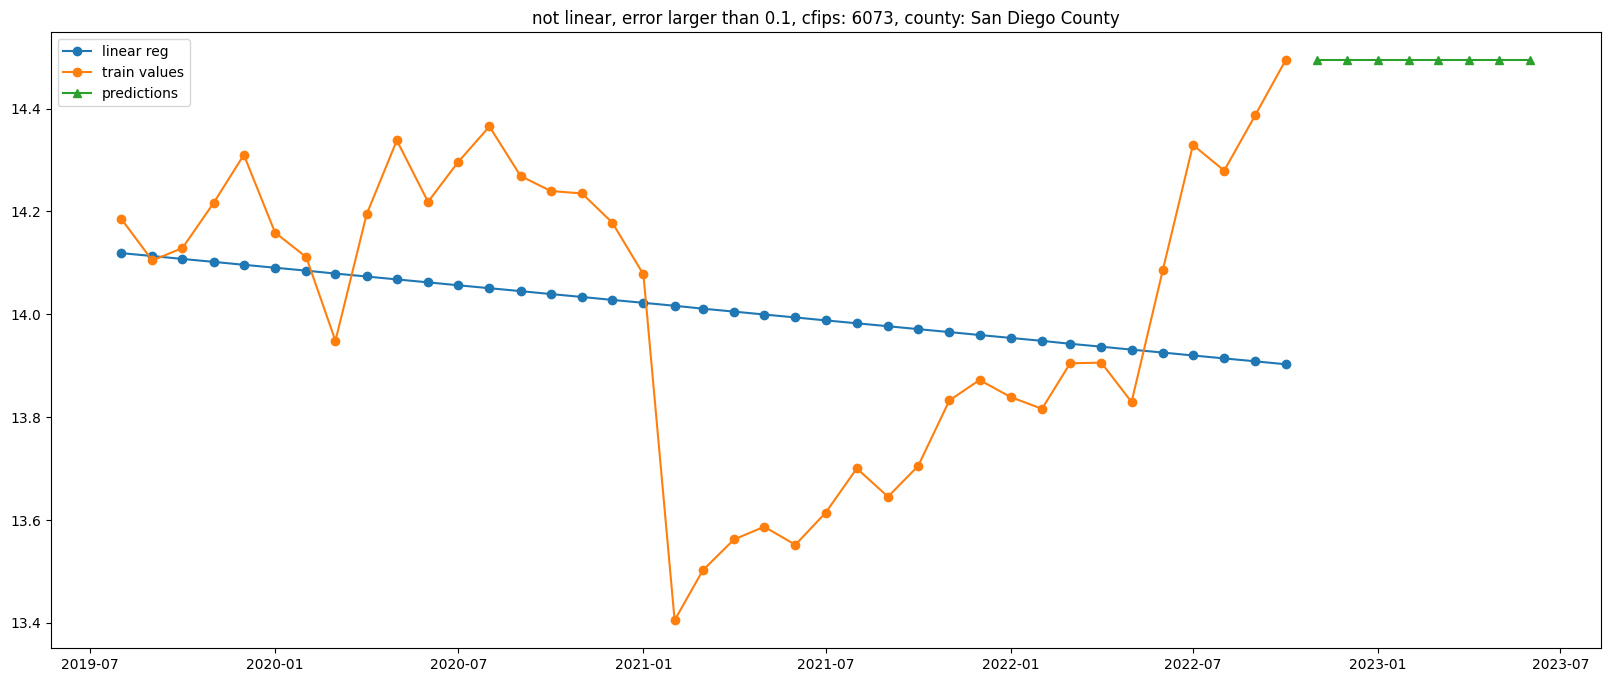

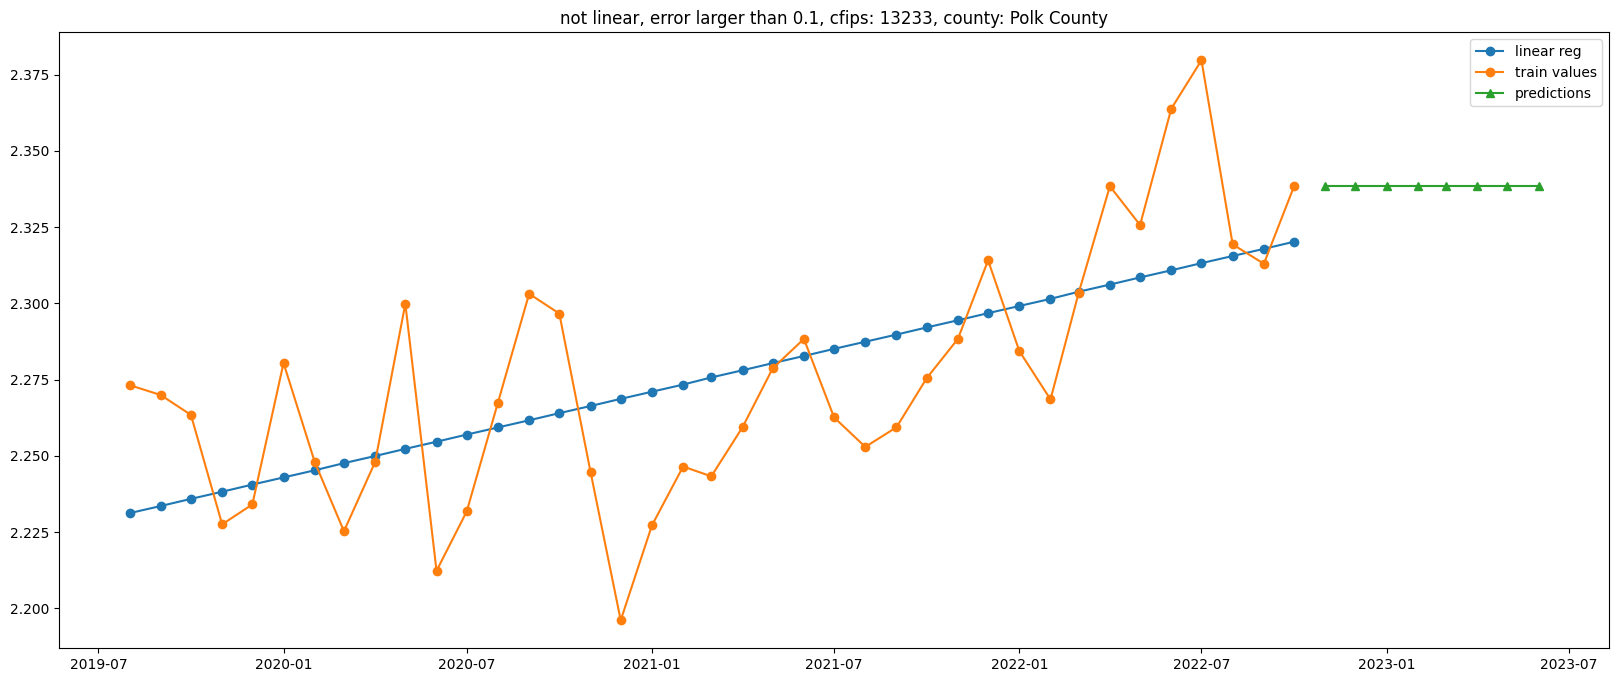

In [36]:
for i in range(10):
    c = np.random.choice(ids)
    train_df = train[train["cfips"] == c]
    last_target = train_df["microbusiness_density"].values[-1]

    model = LinearRegression()
    model.fit(x_train, train_df["microbusiness_density"])

    pred_train = model.predict(x_train)
    # error
    err = pred_train - train_df["microbusiness_density"].values
    train_range = (
        train_df["microbusiness_density"].max()
        - train_df["microbusiness_density"].min()
    )

    # test
    # DETERMINE IF TIME SERIES IS LINEAR OR NOT
    s = 0
    for k in range(39):
        e = np.abs(err[k])
        r = e / train_range  # absolute error divided by range
        s += r
    s = s / 39  # now S is MAPE mean absolute percentage error
    if s < threshold:
        pred_test = model.predict(x_test)
        shift = last_target - pred_test[0]
        pred_test = pred_test + shift
        print_result = f"linear, error smaller than {threshold}"
    else:
        pred_test = [last_target] * 8
        print_result = f"not linear, error larger than {threshold}"
    # plot
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    plt.plot(train_df["first_day_of_month"], pred_train, "-o", label="linear reg")
    plt.plot(
        train_df["first_day_of_month"],
        train_df["microbusiness_density"],
        "-o",
        label="train values",
    )
    plt.plot(
        test["first_day_of_month"].values[:8], pred_test, "-^", label="predictions"
    )
    plt.title(f"{print_result}, cfips: {c}, county: {train_df['county'].values[0]}")
    plt.legend()
    plt.show()

## Lets do 1 good prediction with this

In [37]:
# Get the threshold for active uses cases, so we can filter out the small counties
active_threshold = np.percentile(train["active"], 15)
type(active_threshold)

numpy.float64

In [39]:
predictions = np.zeros((len(ids), 8))
linear_count = 0
cnt = 0
for i, id in enumerate(ids):
    train_df = train[train["cfips"] == id]
    last_target = train_df["microbusiness_density"].values[-1]
    model = LinearRegression()
    model.fit(x_train, train_df["microbusiness_density"])

    pred_train = model.predict(x_train)
    # error

    err = pred_train - train_df["microbusiness_density"].values
    train_range = (
        train_df["microbusiness_density"].max()
        - train_df["microbusiness_density"].min()
    )

    cnt += 1
    # DETERMINE IF TIME SERIES IS LINEAR OR NOT
    s = 0
    for k in range(39):
        e = np.abs(err[k])
        r = e / train_range  # absolute error divided by range
        s += r
    s = s / 39  # now S is MAPE mean absolute percentage error
    if (s > threshold) | (train_df["active"].values[-1] <= active_threshold):
        pred_test = [last_target] * 8
        print_result = f"not linear, error larger than {threshold}"
        predictions[i] = pred_test
        continue

    pred_test = model.predict(x_test)
    shift = last_target - pred_test[0]
    pred_test = pred_test + shift
    print_result = f"linear, error smaller than {threshold}"
    linear_count += 1

    predictions[i] = pred_test


print("counties that have linear distribution: ", linear_count)
print("total counties: ", cnt)

counties that have linear distribution:  392
total counties:  3135


In [40]:
test["microbusiness_density"] = predictions.reshape(-1)

In [41]:
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.463856
3135,1001_2022-12-01,1001,2022-12-01,3.477060
6270,1001_2023-01-01,1001,2023-01-01,3.490264
9405,1001_2023-02-01,1001,2023-02-01,3.503468
12540,1001_2023-03-01,1001,2023-03-01,3.516672


## Persist

In [ ]:
result = test[["row_id", "microbusiness_density"]]
result.to_csv("../data/submissions/logistic_reg_2.csv", index=False)